In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install neptune
! git clone https://github.com/nipdep/HAR-ZSL-XAI.git --branch pd/PoseAE --single-branch
! mv /content/HAR-ZSL-XAI/src /content/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.8/443.8 KB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.1/135.1 KB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 75.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.8/136.8 KB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 KB 10.2 MB/s eta 0:00:00
Cloning into 'HAR-ZSL-XAI'...
remote: Enumerating objects: 211, done.
remote: Counting objects:

---

In [3]:
data_root = '/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Datasets/Consolidated/PAMPA2'

In [4]:
import os 
from datetime import date, datetime
from tqdm.autonotebook import tqdm
from copy import deepcopy
from collections import defaultdict
import numpy as np 
import numpy.random as random
import pandas as pd
import json
import pickle
from collections import defaultdict, OrderedDict
import neptune

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss


from src.datasets.data import PAMAP2Reader, PAMAP2ReaderV2
# from src.datasets.dataset import PAMAP2Dataset
from src.utils.analysis import action_evaluator
from src.datasets.utils import load_attribute

from src.models.loss import FeatureLoss, AttributeLoss
from src.utils.losses import *
from src.utils.analysis import action_evaluator

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

# from src.running import train_step1, eval_step1

<ipython-input-4-151b9d639ad9>:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
from sklearn.manifold import TSNE
# from umap import UMAP

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

In [6]:
# setup model configurations
config = {
    # general information
    "experiment-name": "test-001", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2", # "PAMAP2", "DaLiAc", "UTD"
    "Model": "RelativeGlobalAttention",
    "sem-space": 'attr',
    # model training configs
    "lr": 0.001,
    "imu_alpha": 0.0001,
    "n_epochs": 15,
    "batch_size": 32,
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    "feat_size": 42, # skel-AE hidden size and IMU-Anc output size
    "semantic_size": 64,
    # dataset configs
    "window_size": 5.21, 
    "overlap": 4.21,
    "freq": 20,
    "seq_len": 50,  # skeleton seq. length
    "seen_split": 0.1,
}

In [7]:
def save_model(model,model_name,unique_name,fold_id):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH,exist_ok=True)
    torch.save({
        "n_epochs" : config["n_epochs"],
        "model_state_dict":model.state_dict(),
        "config": config
    }, f"{PATH}/{unique_name}_{fold_id}.pt")

model_iden = "fold"
notebook_iden = "SORTModel_feature"
models_saves = "model_saves"

In [8]:
IMU_data_path = data_root+'/IMU/Protocol/'
dataReader = PAMAP2ReaderV2(IMU_data_path)
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


/content/src/datasets/data.py:1275: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [9]:
def load_attribute(fpath):
    with open(fpath, "r") as pf:
        json_data = json.load(pf)

    activity_dict = json_data["Activity"]
    attribute_dict = json_data["Attribute"]
    attr_met = np.array(list(json_data["Mark"].values()))
    return activity_dict, attribute_dict, attr_met

In [10]:
# load video dataset
Attr_data_path  = data_root + '/Attribute/PAMAP2_attributes.json'
activity_dict, attribute_dict, attr_mat = load_attribute(Attr_data_path)
_, attr_size = attr_mat.shape

In [11]:
activity_dict

{'lying': 0,
 'sitting': 1,
 'standing': 2,
 'walking': 3,
 'running': 4,
 'cycling': 5,
 'nordic walking': 6,
 'watching tv': 7,
 'computer work': 8,
 'car driving': 9,
 'ascending stairs': 10,
 'descending stairs': 11,
 'vacuum cleaning': 12,
 'ironing': 13,
 'folding laundry': 14,
 'house cleaning': 15,
 'playing soccer': 16,
 'rope jumping': 17}

In [12]:
## re-arrange semantic space 
semantic_space = []
for c in actionList:
    p = activity_dict[c.lower()]
    semantic_space.append(attr_mat[p, ...])

semantic_space = np.array(semantic_space)

In [13]:
class PAMAP2Dataset(Dataset):
    def __init__(self, data, actions, attributes, action_classes, seq_len=120):
        super(PAMAP2Dataset, self).__init__()
        self.data = torch.from_numpy(data)
        self.actions = actions
        self.seq_len = seq_len
        self.attributes = torch.from_numpy(attributes)
        self.action_classes = action_classes
        # build action to id mapping dict
        self.n_action = len(self.actions)
        self.action2Id = dict(zip(action_classes, range(self.n_action)))

    def __getitem__(self, ind):
        x = self.data[ind, ...]
        target = self.actions[ind]
        y = torch.from_numpy(np.array([self.action2Id[target]]))
        # extraction semantic space generation skeleton sequences
        y_feat = self.attributes[target, ...]
        return x, y, y_feat

    def __len__(self):
        return self.data.shape[0]

    def getClassAttrs(self):
        sampling_idx = [random.choice(self.attribute_dict[i]) for i in self.action_classes]
        ft_mat = self.attributes[sampling_idx, ...]
        return ft_mat

    def getClassFeatures(self):
        cls_feat = self.attributes[self.action_classes, ...]
        return cls_feat

In [14]:
class IMUEncoder(nn.Module):
    def __init__(self, in_ft, d_model, ft_size, n_classes, num_heads=1, max_len=1024, dropout=0.1):
        super(IMUEncoder, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 
        self.n_classes = n_classes

        self.lstm = nn.LSTM(input_size=self.in_ft,
                            hidden_size=self.d_model,
                            num_layers=self.num_heads,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.1)
        self.act = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.fcLayer1 = nn.Linear(2*self.d_model, self.ft_size)
        # self.fcLayer2 = nn.Linear(self.ft_size, self.ft_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out_forward = out[:, self.max_len - 1, :self.d_model]
        out_reverse = out[:, 0, self.d_model:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        out = self.drop(out_reduced)
        out = self.act(out)
        out = self.fcLayer1(out)
        out = self.sigmoid(out)
        # out = self.fcLayer2(out)
        return out

---

In [15]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
# run 5-fold running
fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

In [17]:
def loss_cross_entropy(y_pred, cls, selected_features, loss_fn=nn.CrossEntropyLoss(reduction="mean")):
    num_classes = selected_features.size()[0]

    cosine_sim_comb = []
    for entry in y_pred.unbind():
        #print(entry.repeat(num_classes,1),selected_features.size())
        cosine_sim = F.softmax(torch.abs(F.cosine_similarity(entry.repeat(num_classes,1),selected_features)),dim=-1)
        cosine_sim_comb.append(cosine_sim)

    cosine_sim_comb = torch.stack(cosine_sim_comb)
    loss = loss_fn(cosine_sim_comb,cls)
    return loss

def loss_reconstruction_calc(y_pred, y_feat, loss_fn=nn.L1Loss(reduction="sum")):
    bat_size,feature_size = y_pred.size()
    loss = loss_fn(y_pred,y_feat)*(1/feature_size)
    return loss

def predict_class(y_pred, selected_features):

    num_classes = selected_features.size()[0]

    cosine_sim_comb = []
    for entry in y_pred.unbind():
        cosine_sim = torch.argmax(F.softmax(torch.abs(F.cosine_similarity(entry.repeat(num_classes,1),selected_features)),dim=-1))
        cosine_sim_comb.append(cosine_sim)

    pred = torch.stack(cosine_sim_comb)
    return pred

In [18]:
def train_step(model, dataloader, dataset:PAMAP2Dataset, optimizer, loss_module, device, class_names, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    random_selected_feat = dataset.getClassFeatures().to(device)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss = loss_cross_entropy(feat_output, targets.squeeze(), random_selected_feat, loss_fn =loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output, target_feat, loss_fn=loss_module["feature"])

            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            class_output = predict_class(feat_output, random_selected_feat)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class using cosine
            pred_class = class_output.cpu().detach().numpy()
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)

    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [19]:
def eval_step(model, dataloader,dataset, loss_module, device, class_names,  phase='seen', l2_reg=False, print_report=True, loss_alpha=0.7):
    model = model.eval()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    random_selected_feat = dataset.getClassFeatures().to(device)
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}
    metrics = {"samples": 0, "loss": 0, "feat. loss": 0, "classi. loss": 0}

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # forward track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss = loss_cross_entropy(feat_output, targets.squeeze(), random_selected_feat, loss_fn =loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output, target_feat, loss_fn=loss_module["feature"])
            
            loss = feat_loss + loss_alpha*class_loss
            class_output = predict_class(feat_output, random_selected_feat)

            # convert feature vector into action class using cosine
            if phase == 'seen':
                pred_action = class_output
            else:
                #feat_numpy = torch.sigmoid(feat_output.cpu().detach())
                #action_probs = cosine_similarity(feat_numpy, target_feat_met)
                pred_action = class_output

            with torch.no_grad():
                metrics['samples'] += len(targets)
                metrics['loss'] += loss.item()  # add total loss of batch
                metrics['feat. loss'] += feat_loss.item()
                metrics['classi. loss'] += class_loss.item()

            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action.cpu().numpy())
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report)
    metrics_dict.update(metrics)
    return metrics_dict

In [20]:
def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['feat. loss'] = df['feat. loss']/df['samples']
    df['classi. loss'] = df['classi. loss']/df['samples']
    
    fig, axs = plt.subplots(nrows=4)
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[2]).set(title="Loss")
    sns.lineplot(data=df, x='epoch', y='feat. loss', hue='phase', marker='o', ax=axs[0]).set(title="Feature Loss")
    sns.lineplot(data=df, x='epoch', y='classi. loss', hue='phase', marker='o', ax=axs[1]).set(title="Classification Loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[3]).set(title="Accuracy")

In [21]:
def log(fold, phase, metrics):
    for m, v in metrics.items():
        if fold == 'global':
            run[f'global/{m}'].log(v)
        else:
            run[f"Fold-{fold}/{phase}/{m}"].log(v) 

In [22]:
run = neptune.init_run(
    project="FYP-Group22/ICANN-Logs",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNWJjMDdhNC05NWY5LTQwNWQtYTQyNi0zNjNmYmYwZDg3M2YifQ==",
)  # your credentials

<ipython-input-22-0fd58e113600>:1: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/FYP-Group22/ICANN-Logs/e/IC-45


================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']


<ipython-input-23-8f44ae85c480>:1: NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'datetime.date'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type
  run['parameters'] = config


seen classes >  [0, 1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 17]
unseen classes >  [7, 15, 2, 10]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

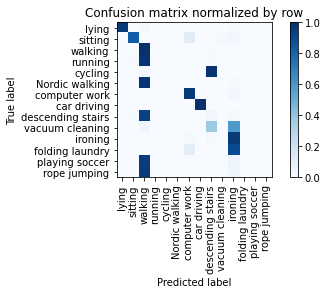

Overall accuracy: 0.557



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

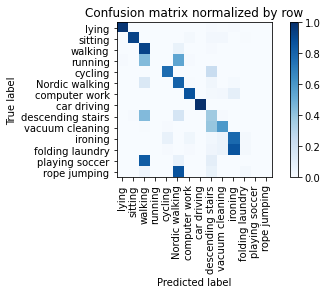

Overall accuracy: 0.707



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

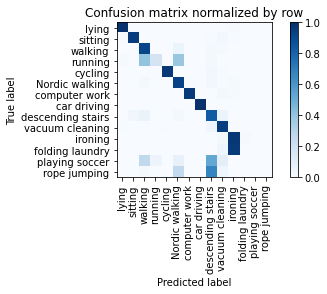

Overall accuracy: 0.829



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

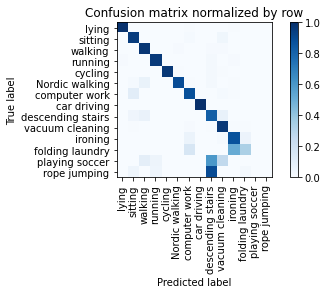

Overall accuracy: 0.859



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

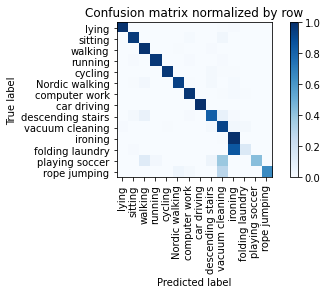

Overall accuracy: 0.904



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

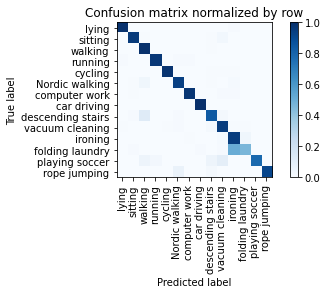

Overall accuracy: 0.934



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

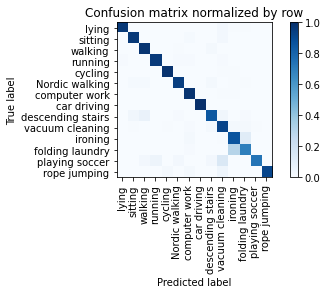

Overall accuracy: 0.929



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

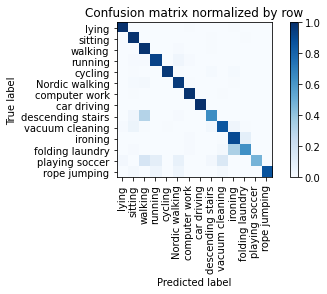

Overall accuracy: 0.913



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

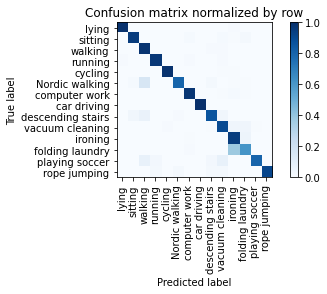

Overall accuracy: 0.925



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

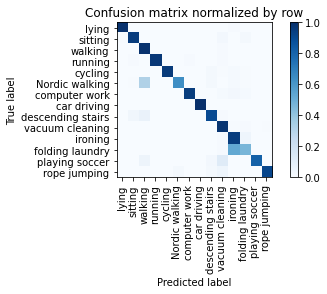

Overall accuracy: 0.909



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

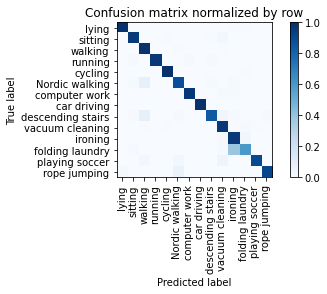

Overall accuracy: 0.941



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

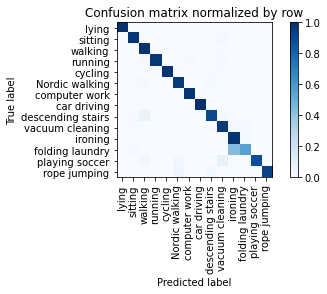

Overall accuracy: 0.951



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

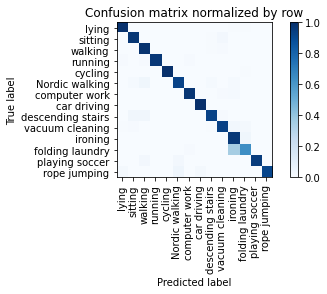

Overall accuracy: 0.950



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

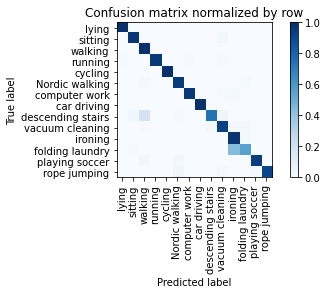

Overall accuracy: 0.941



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

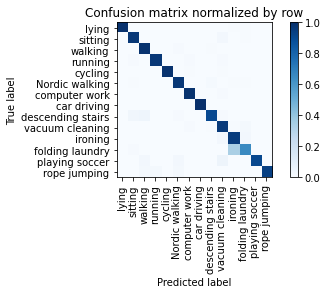

Overall accuracy: 0.955



unseen:   0%|          | 0/175 [00:00<?, ?batch/s]

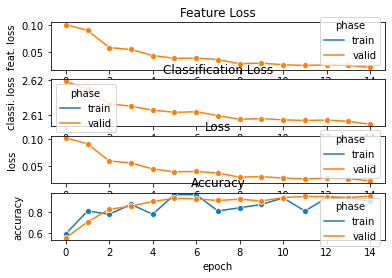

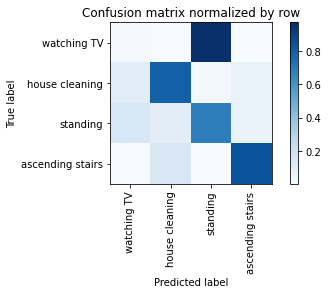

Overall accuracy: 0.649

{'accuracy': 0.6489285714285714, 'precision': 0.5512659157910529, 'recall': 0.5813742834428394, 'f1': 0.5651126988746209, 'samples': 5600, 'loss': 908.5274839401245, 'feat. loss': 907.7710156440735, 'classi. loss': 7564.702865600586}
================ Fold-1 ================
Unseen Classes : ['walking', 'rope jumping', 'sitting', 'descending stairs']
seen classes >  [0, 2, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16]
unseen classes >  [3, 17, 1, 11]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

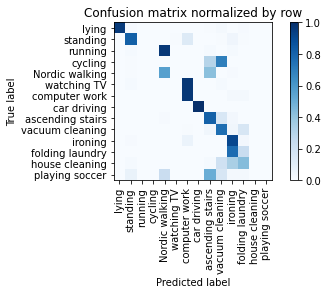

Overall accuracy: 0.601



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

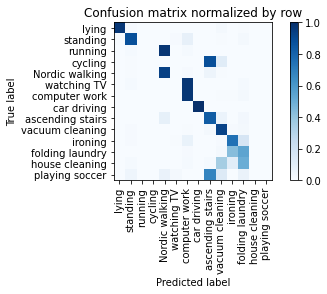

Overall accuracy: 0.651



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

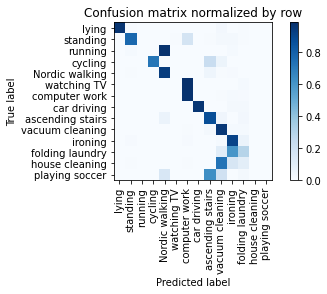

Overall accuracy: 0.715



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

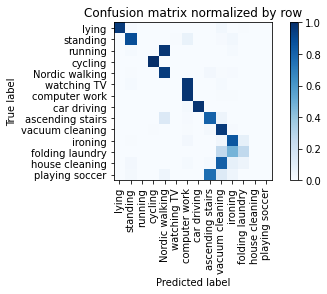

Overall accuracy: 0.736



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

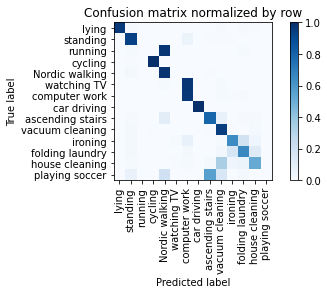

Overall accuracy: 0.776



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

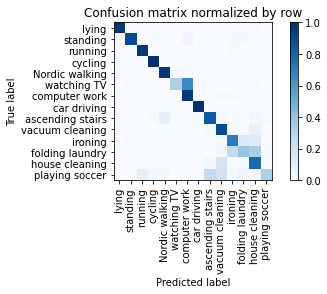

Overall accuracy: 0.843



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

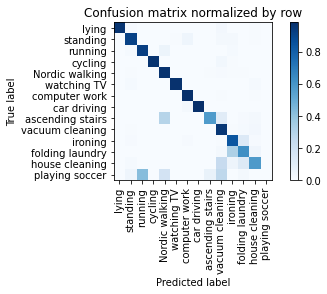

Overall accuracy: 0.854



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

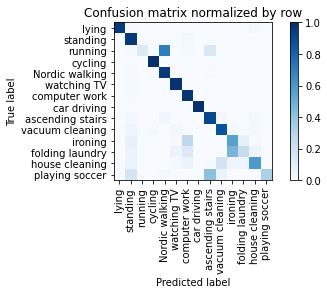

Overall accuracy: 0.802



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

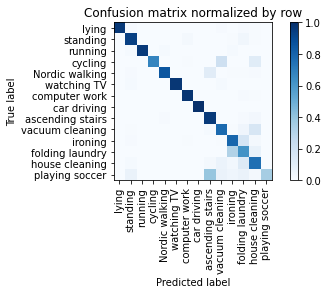

Overall accuracy: 0.848



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

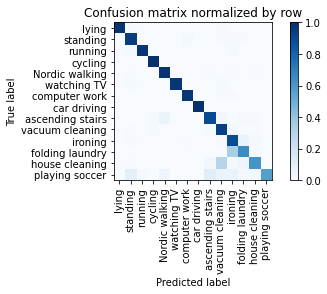

Overall accuracy: 0.905



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

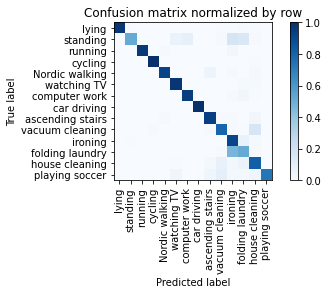

Overall accuracy: 0.865



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

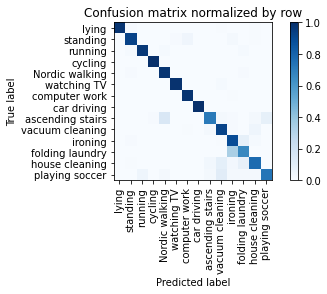

Overall accuracy: 0.909



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

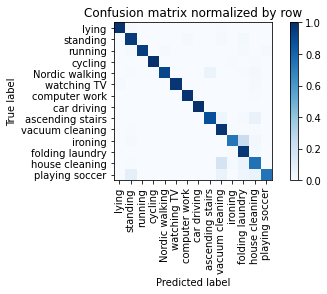

Overall accuracy: 0.914



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

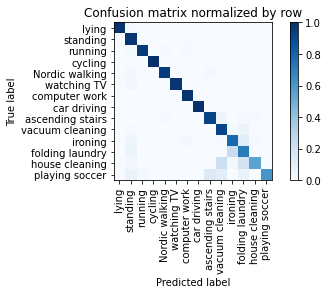

Overall accuracy: 0.893



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

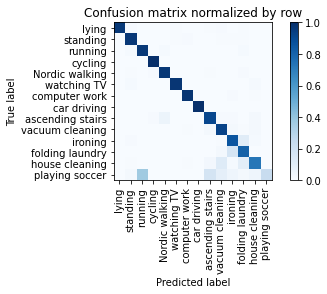

Overall accuracy: 0.911



unseen:   0%|          | 0/173 [00:00<?, ?batch/s]

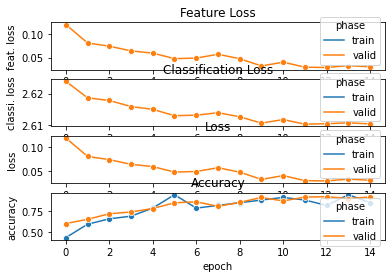

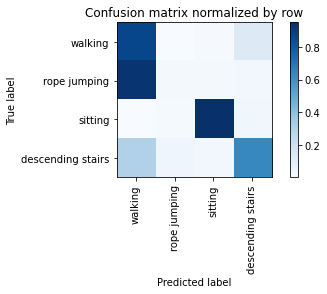

Overall accuracy: 0.782

{'accuracy': 0.7821531791907514, 'precision': 0.6141579448158099, 'recall': 0.6168928505840676, 'f1': 0.6045462896215639, 'samples': 5536, 'loss': 693.750697851181, 'feat. loss': 693.0103611946106, 'classi. loss': 7403.387481689453}
================ Fold-2 ================
Unseen Classes : ['playing soccer', 'lying', 'vacuum cleaning', 'computer work']
seen classes >  [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 17]
unseen classes >  [16, 0, 12, 8]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

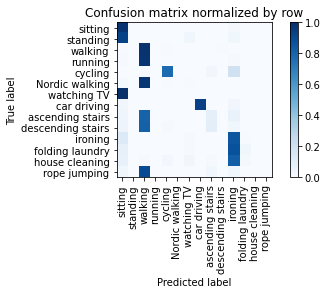

Overall accuracy: 0.382



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

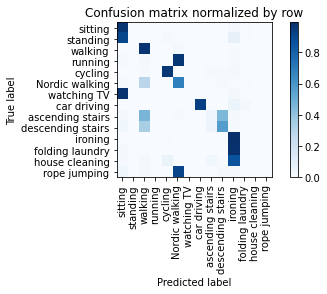

Overall accuracy: 0.498



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

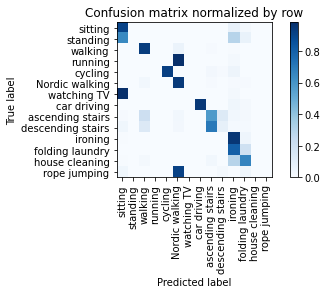

Overall accuracy: 0.527



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

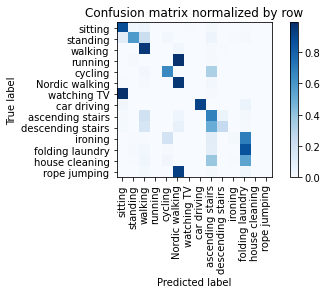

Overall accuracy: 0.512



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

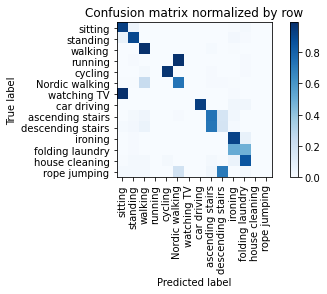

Overall accuracy: 0.630



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

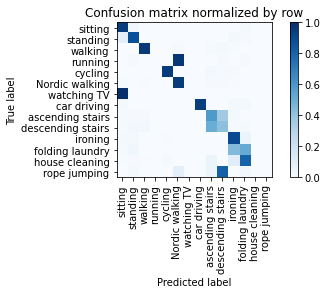

Overall accuracy: 0.655



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

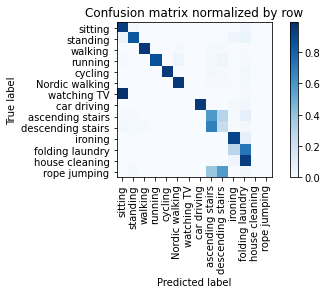

Overall accuracy: 0.698



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

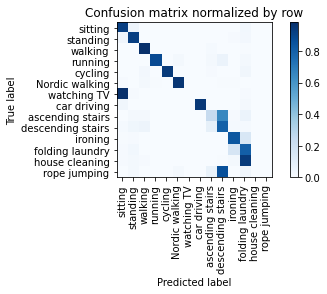

Overall accuracy: 0.711



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

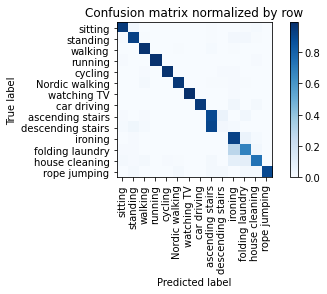

Overall accuracy: 0.871



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

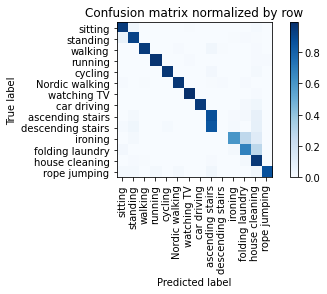

Overall accuracy: 0.846



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

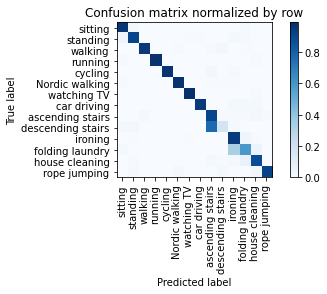

Overall accuracy: 0.890



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

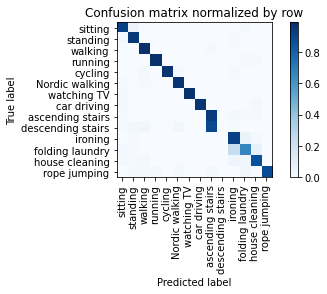

Overall accuracy: 0.886



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

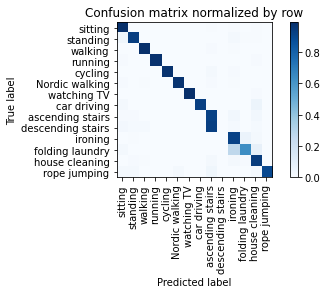

Overall accuracy: 0.895



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

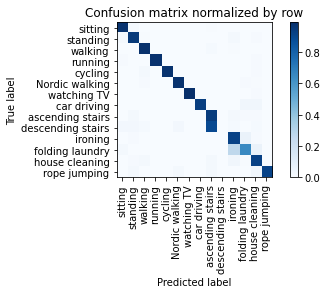

Overall accuracy: 0.896



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

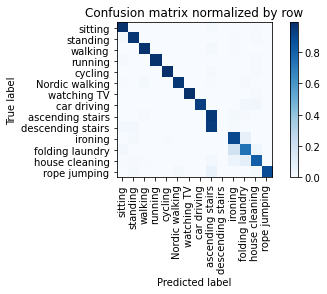

Overall accuracy: 0.890



unseen:   0%|          | 0/222 [00:00<?, ?batch/s]

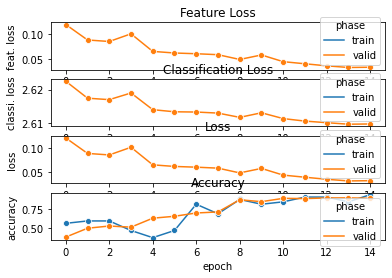

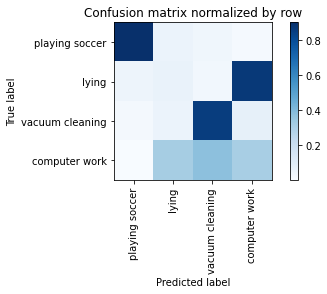

Overall accuracy: 0.412

{'accuracy': 0.4120213963963964, 'precision': 0.4433860351562746, 'recall': 0.5309247416119698, 'f1': 0.47639307633659145, 'samples': 7104, 'loss': 1372.6347942352295, 'feat. loss': 1371.6695885658264, 'classi. loss': 9652.052124023438}
================ Fold-3 ================
Unseen Classes : ['cycling', 'running', 'Nordic walking']
seen classes >  [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
unseen classes >  [5, 4, 6]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

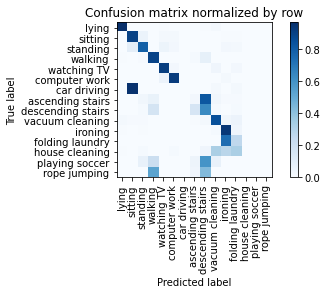

Overall accuracy: 0.690



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

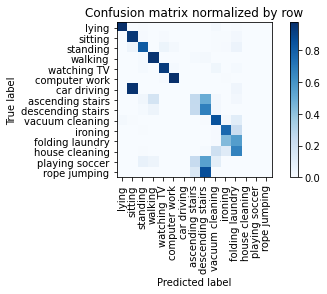

Overall accuracy: 0.721



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

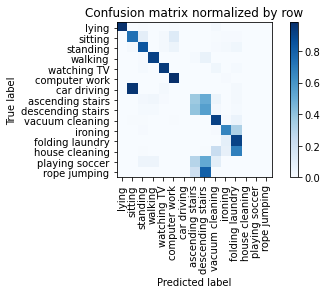

Overall accuracy: 0.716



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

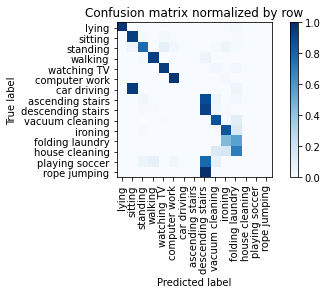

Overall accuracy: 0.725



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

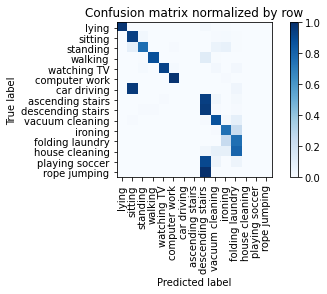

Overall accuracy: 0.717



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

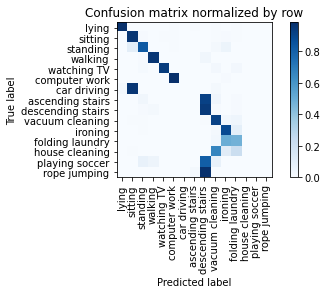

Overall accuracy: 0.737



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

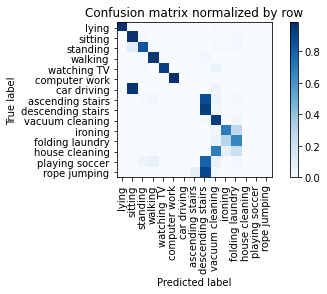

Overall accuracy: 0.730



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

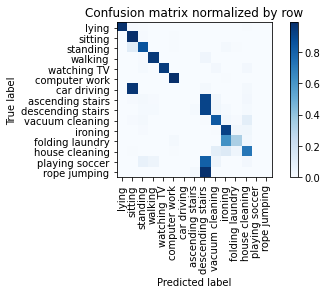

Overall accuracy: 0.781



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

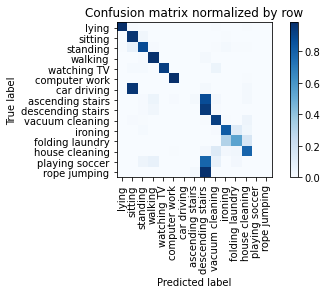

Overall accuracy: 0.797



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

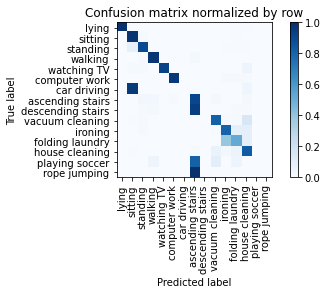

Overall accuracy: 0.802



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

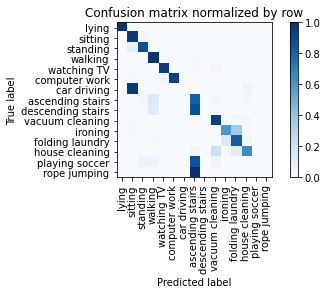

Overall accuracy: 0.779



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

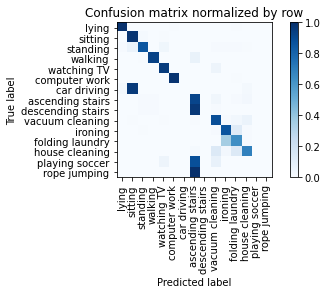

Overall accuracy: 0.803



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

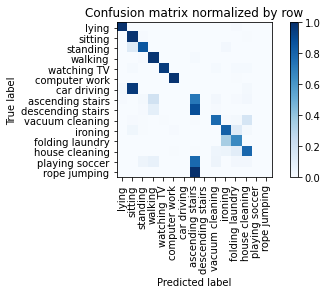

Overall accuracy: 0.793



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

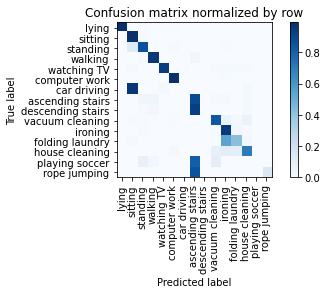

Overall accuracy: 0.805



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

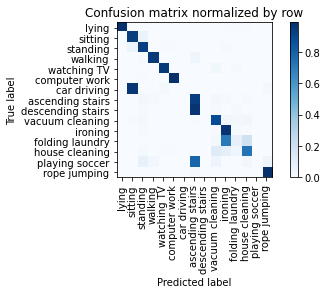

Overall accuracy: 0.818



unseen:   0%|          | 0/137 [00:00<?, ?batch/s]

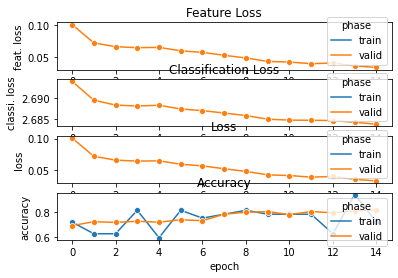

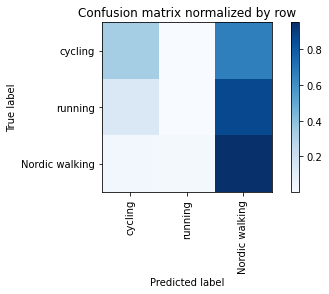

Overall accuracy: 0.523

{'accuracy': 0.5228102189781022, 'precision': 0.4181752163895414, 'recall': 0.4302193648053892, 'f1': 0.36976967291262636, 'samples': 4384, 'loss': 1214.5992107391357, 'feat. loss': 1214.1233234405518, 'classi. loss': 4758.905391693115}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']
seen classes >  [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 15, 16, 17]
unseen classes >  [13, 9, 14]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

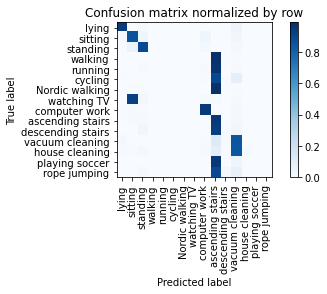

Overall accuracy: 0.443



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

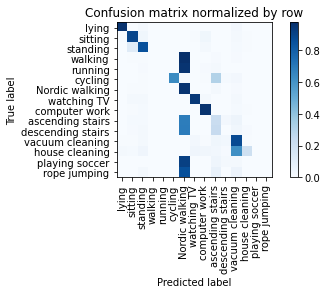

Overall accuracy: 0.584



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

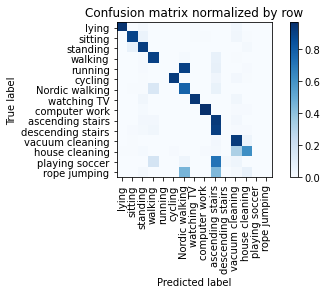

Overall accuracy: 0.770



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

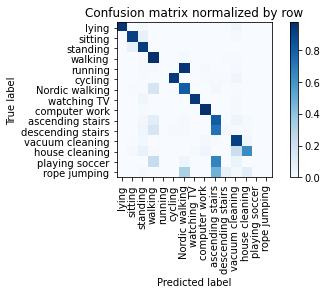

Overall accuracy: 0.780



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

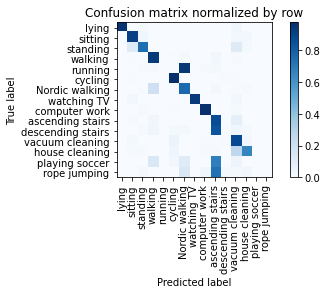

Overall accuracy: 0.762



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

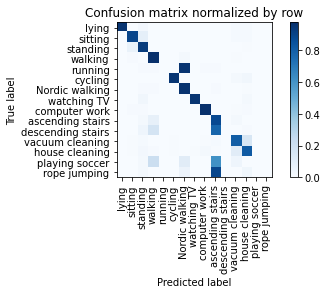

Overall accuracy: 0.802



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

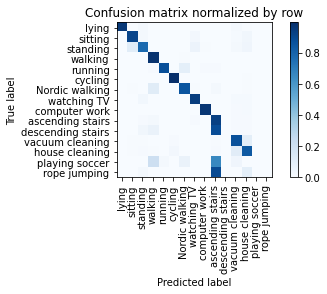

Overall accuracy: 0.831



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

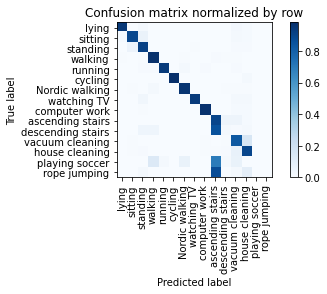

Overall accuracy: 0.854



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

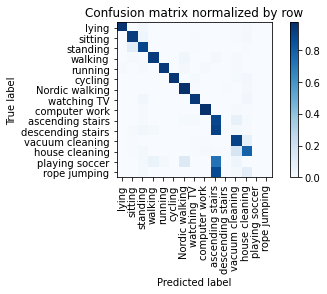

Overall accuracy: 0.842



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

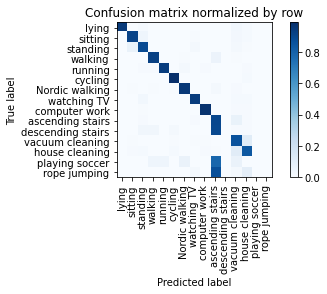

Overall accuracy: 0.843



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

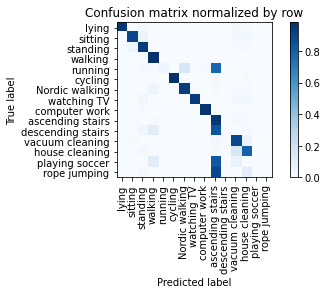

Overall accuracy: 0.813



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

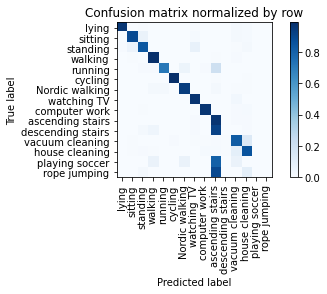

Overall accuracy: 0.834



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

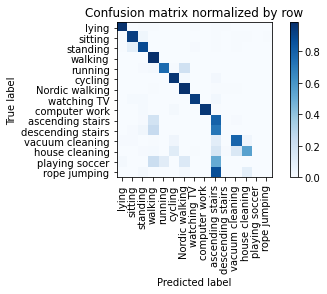

Overall accuracy: 0.808



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

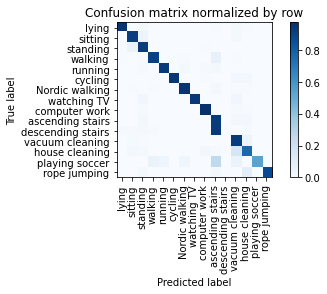

Overall accuracy: 0.875



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

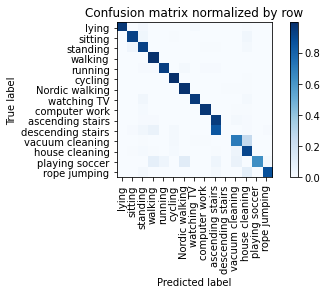

Overall accuracy: 0.889



unseen:   0%|          | 0/120 [00:00<?, ?batch/s]

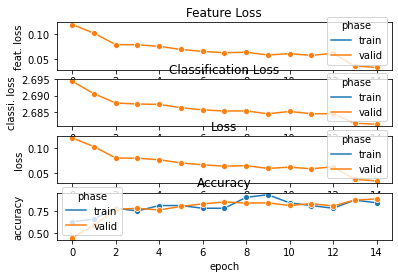

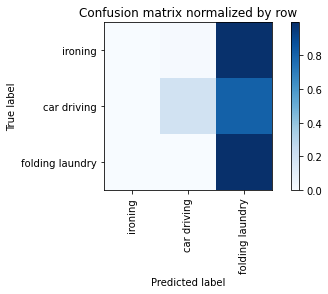

Overall accuracy: 0.278

{'accuracy': 0.27838541666666666, 'precision': 0.3570868970042538, 'recall': 0.39601348925475716, 'f1': 0.24111768936755743, 'samples': 3840, 'loss': 889.2328314781189, 'feat. loss': 888.8168087005615, 'classi. loss': 4160.239414215088}
============== Overall Unseen Classes Performance ==============
accuracy           0.528860
precision          0.476814
recall             0.511085
f1                 0.451388
samples         5292.800000
loss            1015.749004
feat. loss      1015.078220
classi. loss    6707.857455
dtype: float64
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 20 operations to synchronize with Neptune. Do not kill this process.
All 20 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/FYP-Group22/ICANN-Logs/e/IC-45/metadata


In [23]:
run['parameters'] = config
fold_metric_scores = []

for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')

    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=0.8, window_size=config['window_size'], window_overlap=config['overlap'], resample_freq=config['freq'])
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    print("seen classes > ", seen_classes)
    print("unseen classes > ", unseen_classes)
    train_n, seq_len, in_ft = data_dict['train']['X'].shape

    print("Initiate IMU datasets ...")
    # build IMU datasets
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=semantic_space, action_classes=seen_classes, seq_len=100)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=semantic_space, action_classes=seen_classes, seq_len=100)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=semantic_space, action_classes=unseen_classes, seq_len=100)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    # build model
    imu_config = {
        'in_ft':in_ft, 
        'd_model':config['d_model'], 
        'num_heads':config['num_heads'], 
        'ft_size':config['feat_size'], 
        'max_len':seq_len, 
        'n_classes':len(seen_classes)
    }
    model = IMUEncoder(**imu_config)
    model.to(device)

    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'], weight_decay=1e-5)
    loss_module = {'class': nn.CrossEntropyLoss(reduction="sum"), 'feature': nn.L1Loss(reduction="sum")}
    best_acc = 0.0

    # train the model 
    train_data = []
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
    
        train_metrics = train_step(model, train_dl, train_dt,optimizer, loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='train', loss_alpha=0.0001)
        train_metrics['epoch'] = epoch
        train_metrics['phase'] = 'train'
        train_data.append(train_metrics)
        log(i, 'train', train_metrics)

        eval_metrics = eval_step(model, eval_dl, eval_dt,loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='seen', loss_alpha=0.0001, print_report=False)
        eval_metrics['epoch'] = epoch 
        eval_metrics['phase'] = 'valid'
        train_data.append(eval_metrics)
        log(i, 'valid', train_metrics)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    train_df = pd.DataFrame().from_records(train_data)
    plot_curves(train_df)

    # replace by best model 
    model.load_state_dict(best_model)
    # save_model(model,notebook_iden,model_iden,i)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl,test_dt, loss_module, device, class_names=[all_classes[i] for i in unseen_classes], phase='unseen', loss_alpha=0.0001, print_report=False)
    fold_metric_scores.append(test_metrics)
    log('test', i, test_metrics)
    print(test_metrics)
    print("="*40)

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
print(seen_score_df.mean())
log('global', '',seen_score_df.mean().to_dict())
run.stop()
